# Cross Sections

Data Sources:   
BMR:  
 - Richter, O., Gwyther, D. E., Galton-Fenzi, B. K., and Naughten, K. A.: The Whole Antarctic Ocean Model (WAOM v1.0): development and evaluation, Geosci. Model Dev., 15, 617–647, https://doi.org/10.5194/gmd-15-617-2022, 2022.

Grounding Line (2003):
 - Bindschadler, R., & Choi, H. (2011) "High-resolution Image-derived Grounding and Hydrostatic Lines for the Antarctic Ice Sheet" U.S. Antarctic Program (USAP) Data Center. doi: https://doi.org/10.7265/N56T0JK2.

Ice Front (2011):
 - Greene, C. A., A. S. Gardner, N.-J. Schlegel, and A. D. Fraser. 2024. MEaSUREs ITS_LIVE Antarctic
Annual 240 m Ice Sheet Extent Masks, 1997-2021, Version 1. [ice_mask]. Boulder,
Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center.
https://doi.org/10.5067/9ZFX84T5GI6D. [July 2025].

Neutral Density Software:
 - Jackett, David R., Trevor J. McDougall, 1997: A Neutral Density Variable for the World's Oceans. J. Phys. Oceanogr., 27, 237–263. doi: 10.1175/1520-0485(1997)0272.0.CO;2

## Visualising Cross Sections

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd 
from shapely.geometry import LineString

In [4]:
# Prepping data for plotting:

#xlimit = (1009812.2080419888952747, 1191254.7718926025554538)
xlimit = (998543, 1304094)
ylimit = (-2197135.0244829640723765, -2015411.0521906625945121)

tif_path = "CIS_BMR_mask_clipped.tif"
with rasterio.open(tif_path) as src:
    melt = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Convert from m/s to m/yr
s_per_yr = 365.25 * 24 * 60 * 60 
melt = melt * s_per_yr

# Applying the Gaussian smoothing
sigma = 1 
melt_smooth = gaussian_filter(np.nan_to_num(melt, nan=0.0), sigma=sigma)
melt_smooth[np.isnan(melt)] = np.nan

groundingline = gpd.read_file('2003_GL_full_cook_complete_dissolved_larger.shp')
coastline = gpd.read_file('ice_front_2011.shp')
cross_sections = gpd.read_file('cross_sections_3031_v3.shp')

In [6]:
# saving the SMOOTHER geotiff, to be used for framework:

import rasterio
from rasterio.transform import from_bounds

tif_path = "CIS_BMR_mask_clipped.tif"
out_path = "CIS_BMR_mask_clipped_smooth.tif"

with rasterio.open(tif_path) as src:
    profile = src.profile
    transform = src.transform
    melt = src.read(1)

profile.update(
    dtype=rasterio.float32,  
    count=1,
    compress='lzw',
    crs="EPSG:3031"  
)

with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(melt_smooth.astype(rasterio.float32), 1)

# saved as the 'outpath' !!

In [8]:
from matplotlib import rcParams

# Set global font properties
rcParams['font.size'] = 10
rcParams['font.family'] = 'Times New Roman'


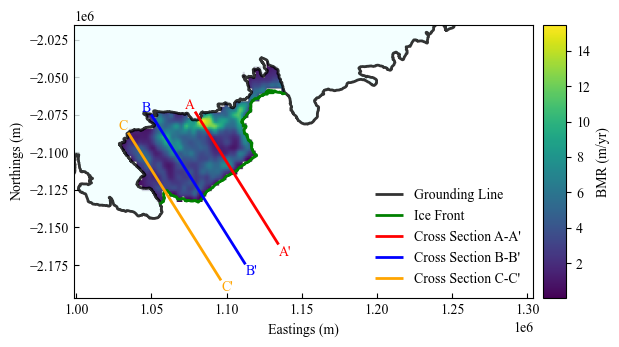

In [16]:


fig, ax = plt.subplots(figsize=(160/25.4, 100/25.4))  # mm to inches
img = ax.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

groundingline.plot(ax=ax, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')
#cross_sections.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Cross Sections')

# CROSS SECTION linestring shapefile plotting:
colors = ['red', 'blue', 'orange']
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
for i, (color, label) in enumerate(zip(colors, labels)):
    cross_sections.iloc[[i]].plot(
        ax=ax, edgecolor=color, facecolor='none', linewidth=2, label=label)
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]
for i, (color, label, (label_start, label_end)) in enumerate(zip(colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]

    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax.text(x_start, y_start, label_start, fontsize=10, fontfamily='Times New Roman',
            color=color, verticalalignment='bottom', horizontalalignment='right')
    ax.text(x_end, y_end, label_end, fontsize=10, fontfamily='Times New Roman',
            color=color, verticalalignment='top', horizontalalignment='left')

# Rest of the plot:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("BMR (m/yr)", fontsize=10, fontfamily='Times New Roman')
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_fontsize(10)
    tick_label.set_family('Times New Roman')

ax.set_xlabel('Eastings (m)', fontsize=10, fontfamily='Times New Roman')
ax.set_ylabel('Northings (m)', fontsize=10, fontfamily='Times New Roman')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)
    label.set_family('Times New Roman')

# Corrects font for the scaling factor
ax.xaxis.get_offset_text().set_fontsize(10)
ax.xaxis.get_offset_text().set_family('Times New Roman')
ax.yaxis.get_offset_text().set_fontsize(10)
ax.yaxis.get_offset_text().set_family('Times New Roman')

ax.tick_params(direction='in')
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
#ax.set_title("Gaussian Smoothed BMR (WAOM)", fontsize=12, fontfamily='Times New Roman')
ax.set_aspect('equal')

legend = ax.legend(loc='lower right', prop={'size': 10, 'family': 'Times New Roman'})
legend.get_frame().set_edgecolor('none')  # Removes the legend border

plt.tight_layout()
#plt.savefig('WAOM_Cross_Section_Cords.jpg', dpi=500, bbox_inches='tight')
plt.show()


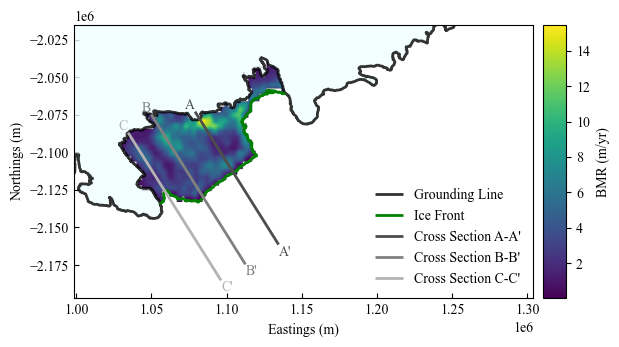

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams

# Set global font
rcParams['font.size'] = 10
rcParams['font.family'] = 'Times New Roman'

# Grayscale colors for cross sections
gray_colors = ['0.3', '0.5', '0.7']  # dark, medium, light gray
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]

# Create figure
fig, ax = plt.subplots(figsize=(160/25.4, 100/25.4))  # mm to inches

# Background raster
img = ax.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

# Shapefiles
groundingline.plot(ax=ax, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')  # black

# Cross-section lines
for i, (color, label) in enumerate(zip(gray_colors, labels)):
    cross_sections.iloc[[i]].plot(ax=ax, edgecolor=color, facecolor='none', linewidth=2, label=label)

# Cross-section labels
for i, (color, label, (label_start, label_end)) in enumerate(zip(gray_colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]
    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax.text(x_start, y_start, label_start, color=color, verticalalignment='bottom', horizontalalignment='right')
    ax.text(x_end, y_end, label_end, color=color, verticalalignment='top', horizontalalignment='left')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("BMR (m/yr)")
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_fontsize(10)
    tick_label.set_family('Times New Roman')

# Axis labels
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Northings (m)')
ax.tick_params(direction='in')
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.set_aspect('equal')

# Legend in grayscale
legend = ax.legend(loc='lower right')
legend.get_frame().set_edgecolor('none')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd


In [12]:
subplot_b = pd.read_csv('subplot_b.csv')

In [14]:
x1 = subplot_b['Year']
y1 = subplot_b['Mean Anomaly']
y2 = subplot_b['Median Anomaly']

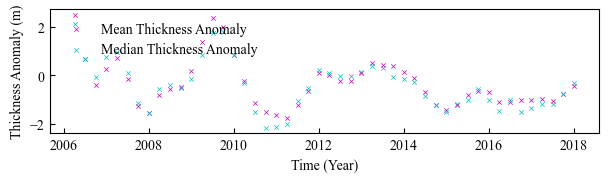

In [16]:
plt.figure().set_size_inches(180/25.4,90/25.4,forward=True)

subplot1 = plt.subplot(211)
subplot1.scatter(x1,y1,label='Mean Thickness Anomaly', marker='x', s=10, linewidths=0.5, c='m')
subplot1.scatter(x1,y2,label='Median Thickness Anomaly', marker='x', s=10, linewidths=0.5, c='c')
subplot1.set_xlabel('Time (Year)') 
subplot1.set_ylabel('Thickness Anomaly (m)') 
subplot1.legend(frameon=False,loc='upper left')
subplot1.tick_params(axis='both', direction='in')

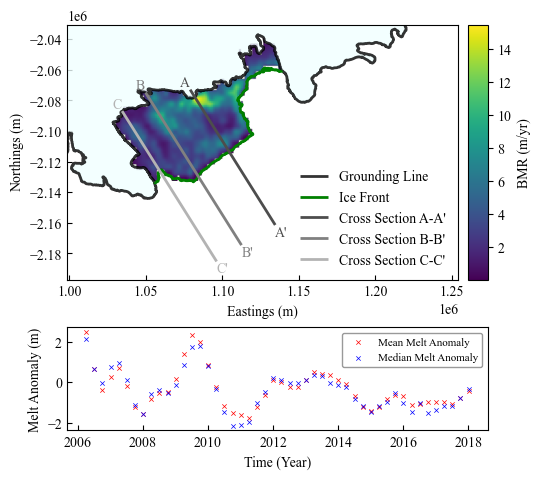

In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams


xlimit = (998543, 1254094)
ylimit = (-2197135.0244829640723765, -2030411.0521906625945121)


# Set global font
rcParams['font.size'] = 10
rcParams['font.family'] = 'Times New Roman'

# Grayscale colors for cross sections
gray_colors = ['0.3', '0.5', '0.7']  # dark, medium, light gray
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]

# Create figure with 2 vertical subplots (map on top, scatter below)
fig, (ax_map, ax_scatter) = plt.subplots(2, 1, figsize=(140/25.4, 130/25.4), gridspec_kw={'height_ratios':[3,1]})

# -----------------------------
# Top subplot: map
# -----------------------------
# Background raster
img = ax_map.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

# Shapefiles
groundingline.plot(ax=ax_map, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax_map, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')

# Cross-section lines
for i, (color, label) in enumerate(zip(gray_colors, labels)):
    cross_sections.iloc[[i]].plot(ax=ax_map, edgecolor=color, facecolor='none', linewidth=2, label=label)

# Cross-section labels
for i, (color, label, (label_start, label_end)) in enumerate(zip(gray_colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]
    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax_map.text(x_start, y_start, label_start, color=color, verticalalignment='bottom', horizontalalignment='right')
    ax_map.text(x_end, y_end, label_end, color=color, verticalalignment='top', horizontalalignment='left')

# Colorbar
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("BMR (m/yr)")

# Axes labels
ax_map.set_xlabel('Eastings (m)')
ax_map.set_ylabel('Northings (m)')
ax_map.tick_params(direction='in')
ax_map.set_xlim(xlimit)
ax_map.set_ylim(ylimit)
ax_map.set_aspect('equal')

# Legend
legend = ax_map.legend(loc='lower right')
legend.get_frame().set_edgecolor('none')

# -----------------------------
# Bottom subplot: scatter
# -----------------------------
ax_scatter.scatter(x1, y1, label='Mean Melt Anomaly', marker='x', s=10, linewidths=0.5, c='r')
ax_scatter.scatter(x1, y2, label='Median Melt Anomaly', marker='x', s=10, linewidths=0.5, c='b')
ax_scatter.set_xlabel('Time (Year)') 
ax_scatter.set_ylabel('Melt Anomaly (m)') 
ax_scatter.legend(
    loc='upper right',
    frameon=True,
    prop={'size': 8}          # set font size
)
ax_scatter.get_legend().get_frame().set_edgecolor('gray')
ax_scatter.get_legend().get_frame().set_linewidth(1)
ax_scatter.tick_params(axis='both', direction='in')

# Adjust layout to avoid overlap
# After creating subplots and plotting
plt.tight_layout()  # optional but keeps things neat
plt.subplots_adjust(hspace=0.1)  # reduce vertical gap; default is ~0.2
plt.show()



In [ ]:
from matplotlib.ticker import FuncFormatter
ax_map.xaxis.set_major_formatter(FuncFormatter(lambda x, _: x/1000))
ax_map.yaxis.set_major_formatter(FuncFormatter(lambda y, _: y/1000))
ax_map.set_xlabel('Eastings (km)')
ax_map.set_ylabel('Northings (km)')


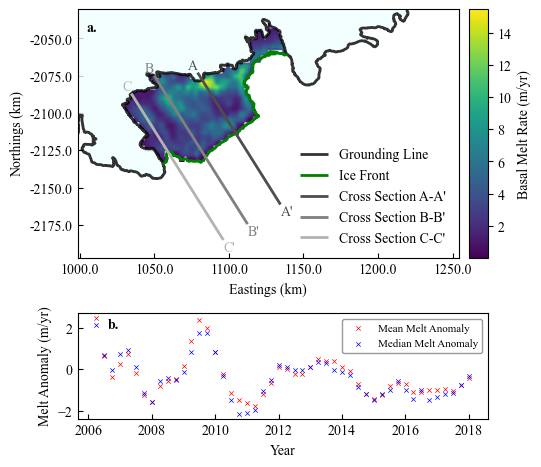

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams


xlimit = (998543, 1254094)
ylimit = (-2197135.0244829640723765, -2030411.0521906625945121)


# Set global font
rcParams['font.size'] = 10
rcParams['font.family'] = 'Times New Roman'

# Grayscale colors for cross sections
gray_colors = ['0.3', '0.5', '0.7']  # dark, medium, light gray
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]

# Create figure with 2 vertical subplots (map on top, scatter below)
fig, (ax_map, ax_scatter) = plt.subplots(2, 1, figsize=(140/25.4, 130/25.4), gridspec_kw={'height_ratios':[3,1]})

# -----------------------------
# Top subplot: map
# -----------------------------
# Background raster
img = ax_map.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

# Shapefiles
groundingline.plot(ax=ax_map, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax_map, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')

# Cross-section lines
for i, (color, label) in enumerate(zip(gray_colors, labels)):
    cross_sections.iloc[[i]].plot(ax=ax_map, edgecolor=color, facecolor='none', linewidth=2, label=label)

# Cross-section labels
for i, (color, label, (label_start, label_end)) in enumerate(zip(gray_colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]
    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax_map.text(x_start, y_start, label_start, color=color, verticalalignment='bottom', horizontalalignment='right')
    ax_map.text(x_end, y_end, label_end, color=color, verticalalignment='top', horizontalalignment='left')

# Colorbar
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("Basal Melt Rate (m/yr)")

# Axes labels
from matplotlib.ticker import FuncFormatter
ax_map.xaxis.set_major_formatter(FuncFormatter(lambda x, _: x/1000))
ax_map.yaxis.set_major_formatter(FuncFormatter(lambda y, _: y/1000))
ax_map.set_xlabel('Eastings (km)')
ax_map.set_ylabel('Northings (km)')

ax_map.tick_params(direction='in')
ax_map.set_xlim(xlimit)
ax_map.set_ylim(ylimit)
ax_map.set_aspect('equal')

# Legend
legend = ax_map.legend(loc='lower right')
legend.get_frame().set_edgecolor('none')

# -----------------------------
# Bottom subplot: scatter
# -----------------------------
ax_scatter.scatter(x1, y1, label='Mean Melt Anomaly', marker='x', s=10, linewidths=0.5, c='r')
ax_scatter.scatter(x1, y2, label='Median Melt Anomaly', marker='x', s=10, linewidths=0.5, c='b')
ax_scatter.set_xlabel('Year') 
ax_scatter.set_ylabel('Melt Anomaly (m/yr)') 
ax_scatter.legend(
    loc='upper right',
    frameon=True,
    prop={'size': 8}          # set font size
)
ax_scatter.get_legend().get_frame().set_edgecolor('gray')
ax_scatter.get_legend().get_frame().set_linewidth(1)
ax_scatter.tick_params(axis='both', direction='in')



# Add subplot labels
ax_map.text(0.05, 0.95, 'a.', transform=ax_map.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')
ax_scatter.text(0.1, 0.95, 'b.', transform=ax_scatter.transAxes,
                fontsize=10, fontweight='bold', va='top', ha='right')

# Adjust layout to avoid overlap
# After creating subplots and plotting
plt.tight_layout()  # optional but keeps things neat
plt.subplots_adjust(hspace=0.1)  # reduce vertical gap; default is ~0.2

#plt.savefig('Final_Fig_3.jpg', dpi=500, bbox_inches='tight')

plt.show()



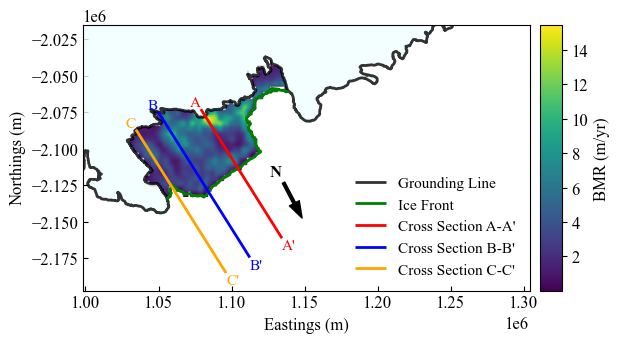

In [251]:
# Plotting the data

fig, ax = plt.subplots(figsize=(160/25.4, 100/25.4))  # mm to inches
img = ax.imshow(melt_smooth, cmap='viridis', origin='upper', extent=extent)

groundingline.plot(ax=ax, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line', alpha=0.8)
coastline.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2, label='Ice Front')
#cross_sections.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Cross Sections')

# CROSS SECTION linestring shapefile plotting:
colors = ['red', 'blue', 'orange']
labels = ["Cross Section A-A'", "Cross Section B-B'", "Cross Section C-C'"]
for i, (color, label) in enumerate(zip(colors, labels)):
    cross_sections.iloc[[i]].plot(
        ax=ax, edgecolor=color, facecolor='none', linewidth=2, label=label)
endpoint_labels = [("A", "A'"), ("B", "B'"), ("C", "C'")]
for i, (color, label, (label_start, label_end)) in enumerate(zip(colors, labels, endpoint_labels)):
    line = cross_sections.geometry.iloc[i]

    if line.geom_type == "MultiLineString":
        line = list(line.geoms)[0]
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    ax.text(x_start, y_start, label_start, fontsize=11, fontfamily='Times New Roman',
            color=color, verticalalignment='bottom', horizontalalignment='right')
    ax.text(x_end, y_end, label_end, fontsize=11, fontfamily='Times New Roman',
            color=color, verticalalignment='top', horizontalalignment='left')

# Rest of the plot:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("BMR (m/yr)", fontsize=12, fontfamily='Times New Roman')
for tick_label in cbar.ax.get_yticklabels():
    tick_label.set_fontsize(12)
    tick_label.set_family('Times New Roman')

ax.set_xlabel('Eastings (m)', fontsize=12, fontfamily='Times New Roman')
ax.set_ylabel('Northings (m)', fontsize=12, fontfamily='Times New Roman')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
    label.set_family('Times New Roman')

# Corrects font for the scaling factor
ax.xaxis.get_offset_text().set_fontsize(12)
ax.xaxis.get_offset_text().set_family('Times New Roman')
ax.yaxis.get_offset_text().set_fontsize(12)
ax.yaxis.get_offset_text().set_family('Times New Roman')

ax.tick_params(direction='in')
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
#ax.set_title("Gaussian Smoothed BMR (WAOM)", fontsize=12, fontfamily='Times New Roman')
ax.set_aspect('equal')

legend = ax.legend(loc='lower right', prop={'size': 11, 'family': 'Times New Roman'})
legend.get_frame().set_edgecolor('none')  # Removes the legend border

##########################################################################################
from pyproj import Transformer
import numpy as np

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326", always_xy=True)
x0 = 1130484
y0 = -2116254
arrow_length = 36000  
lon, lat = transformer.transform(x0, y0)
x_north, y_north = transformer.transform(lon, lat, direction='INVERSE')
angle = np.arctan2(y_north - y0, x_north - x0)
ax.annotate('N',
            xy=(x0 + arrow_length*np.cos(angle), y0 + arrow_length*np.sin(angle)),
            xytext=(x0, y0),
            arrowprops=dict(facecolor='black', width=2, headwidth=8),
            ha='center', va='center',
            fontsize=12, fontweight='bold', fontfamily='Times New Roman')
##########################################################################################
plt.tight_layout()
#plt.savefig('Figure_1.jpg', dpi=500, bbox_inches='tight')
plt.show()


## Notes / Prep for MATLAB EOS80 Legacy Code - Cross Section Neutral Densities

FUNCTION TO USE IN MATLAB: " [gamma_n] = eos80_legacy_gamma_n(SP,t,p,long,lat)  "
  
'Calculates netural density value, gamma_n, in the open ocean by spatially interpolating the global reference data set, gamma_n_ref, to the location of the seawater sample.  
'The input variables are those of EOS-80:  
 - SP = practical salinity, unitless
 - t = in-situ temperature (ITS-90), deg C
 - p = sea pressure, dbar (i.e. absolute pressure - 10.1325 dbar)
 - long = longitude in decimal degrees, [0 to +360] or [-180 to +180]
 - lat = latitude in decimal degrees north, [-90 to +90]
  
SP and t need to have the same dimensions  
p, lat & lon may have dimensions 1x1 or 1xN or MxN, where SP & t is MxN  
  
OUTPUT: gamma_n = neutral density, kg m^-3

## Prepping Data for Extraction

In [195]:
import numpy as np
import rasterio
import xarray as xr


In [197]:
# Preparing the z_rho for depth extraction

with rasterio.open("z_rho_3031.tif") as src:
    z_rho = src.read() 
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(transform, rows, cols)
X = np.array(xs)  
Y = np.array(ys)

In [199]:
# Preparing the NetCDF file for variable extraction

ds = xr.open_dataset("WAOM_Variables_3031.nc")
temperature = ds['temp_3031'].values  
salinity = ds['salt_3031'].values 

# Cross Section for A to A'

In [155]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import gsw
from scipy.io import savemat
from scipy.io import loadmat
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

### Prepping Data (Cross Section Spatial Cords)

In [53]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1078998.1917, 1134587.8693
ymin, ymax = -2072930.4516, -2161360.5337

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [191]:
z_levels = temperature.shape[0]

NameError: name 'temperature' is not defined

In [18]:
# This interpolates the depths and variable data
z_levels = temperature.shape[0]
temp_section_1 = np.zeros((z_levels, n_points))
salt_section_1 = np.zeros((z_levels, n_points))
depth_section_1 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
    salt_k = salinity[k, :, :] 
    z_k = z_rho[k, :, :]         

    # Interpolate each level
    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_1[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')
    salt_section_1[k, :] = griddata(points, salt_k.ravel(), (x_line, y_line), method='linear')
    depth_section_1[k, :] = griddata(points, z_k.ravel(), (x_line, y_line), method='linear')


In [24]:
# Saves these variables as a .npy file, so I don't have to wait to interpolate them again in the future.
np.save("temp_section_1.npy", temp_section_1)
np.save("salt_section_1.npy", salt_section_1)
np.save("depth_section_1.npy", depth_section_1)

In [35]:
# Loads these variables back in
temp_section_1 = np.load("temp_section_1.npy")
salt_section_1 = np.load("salt_section_1.npy")
depth_section_1 = np.load("depth_section_1.npy")

In [18]:
print("Shallowest depth (max):", np.max(depth_section_1))
print("Deepest depth (min):", np.min(depth_section_1))

Shallowest depth (max): -8.614647598124701
Deepest depth (min): -893.8812613581615


### Calculating / Prepping Neutral Densities

In [30]:
# This section calculates the neutral densities based off of the depth, salinity and temperature data from the previous cell ^^^

# Calculating absolute pressure from z_rho depth:
depth = depth_section_1
lat = -68.5    # This refers to the centre of the CIS
absolute_pressure = gsw.p_from_z(depth, lat)
sea_pressure = absolute_pressure - 10.1325
p = sea_pressure

# Calculating salt and temp inputs
SP = salt_section_1 # This is practical salinity (PSU)
pt = temp_section_1 # This is potential temperature
lon = 152.5 # This refers to the centre of the CIS
lat = -68.5 # This refers to the centre of the CIS

# Need to convert potential temperature to in-situ temperature: bit awkward as it's a two-step process;
SA = gsw.SA_from_SP(SP, p, lon, lat) # This converts practical to absolute salinity
CT = gsw.CT_from_pt(SA, pt) # This converts potential to conservative temp
T = gsw.t_from_CT(SA, CT, p) # Finally, this converts conservative to in-situ temp, using the pressure inputs

# Saving the data
SP = SP
t = T
p = p

print(SP.shape)
print(t.shape)
print(p.shape)

# Save as .mat
savemat("gamma_n_inputs_section_1.mat", {"SP": SP, "t": t, "p": p})


(31, 300)
(31, 300)
(31, 300)


FROM HERE, open MATLAB and run the file 'calculating_gamma_n_for_cross_sections.mat'  
ENSURE that you have downloaded these codes: https://www.teos-10.org/preteos10_software/neutral_density.html 

In [37]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data = loadmat('gamma_n_outputs_section_1.mat')
gamma_n_section_1 = data['gamma_n']  # numpy array


### Plotting Data

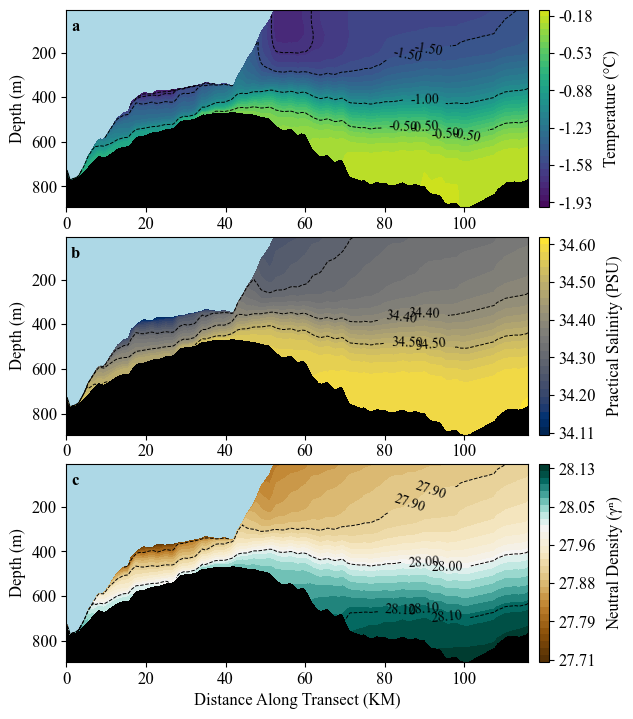

In [246]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_1

fig, axs = plt.subplots(3, 1, figsize=(160/25.4, 180/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_1, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_1, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_1)
vmax_temp = np.nanmax(temp_section_1)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_1, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_1, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_1)
vmax = np.nanmax(salt_section_1)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_1)
vmax = np.nanmax(gamma_n_section_1)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_1, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_1, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})


# Subplot Labels
labels = ['a', 'b', 'c']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_A_Temp_Salt_Dens.jpg', dpi=500, bbox_inches='tight')
plt.show()


### Plotting Data with Parcels

In [47]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm

In [49]:
DSW_mask = (temp_section_1 > - 1.92) & (temp_section_1 < -1.8) & (salt_section_1 > 34.4) & (gamma_n_section_1 > 28.27)
mCDW_mask = (temp_section_1 > -1.7) & (temp_section_1 < 1.5) & (gamma_n_section_1 > 28) & (gamma_n_section_1 < 28.27)
ASW_mask = (gamma_n_section_1 < 28)

In [51]:
water_parcels = np.full(temp_section_1.shape, np.nan)
water_parcels[DSW_mask] = 0.5 # mode 1 melting
water_parcels[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

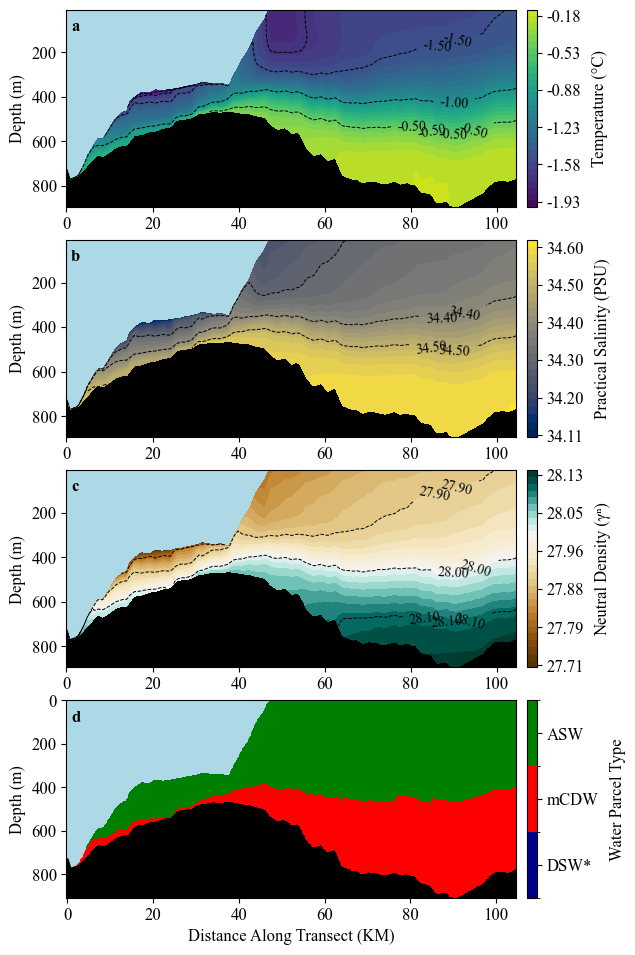

In [57]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_1

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_1, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_1, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_1)
vmax_temp = np.nanmax(temp_section_1)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_1, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_1, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_1)
vmax = np.nanmax(salt_section_1)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_1)
vmax = np.nanmax(gamma_n_section_1)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_1, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_1, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec.max(axis=0), 905, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot Labels
labels = ['a', 'b', 'c', 'd']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_A_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


# Cross Section for B to B'

In [52]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import gsw
from scipy.io import savemat
from scipy.io import loadmat
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

### Prepping Data (Cross Section Spatial Cords)

In [37]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1049863.9700000092852861, 1112546.3867892120033503  
ymin, ymax = -2074869.5600000144913793, -2174544.8276608600281179 

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [39]:
z_levels = temperature.shape[0]

In [90]:
# This interpolates the depths and variable data
z_levels = temperature.shape[0]
temp_section_2 = np.zeros((z_levels, n_points))
salt_section_2 = np.zeros((z_levels, n_points))
depth_section_2 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
    salt_k = salinity[k, :, :] 
    z_k = z_rho[k, :, :]         

    # Interpolate each level
    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_2[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')
    salt_section_2[k, :] = griddata(points, salt_k.ravel(), (x_line, y_line), method='linear')
    depth_section_2[k, :] = griddata(points, z_k.ravel(), (x_line, y_line), method='linear')


In [103]:
# Saves these variables as a .npy file, so I don't have to wait to interpolate them again in the future.
np.save("temp_section_2.npy", temp_section_2)
np.save("salt_section_2.npy", salt_section_2)
np.save("depth_section_2.npy", depth_section_2)

In [264]:
# Loads these variables back in
temp_section_2 = np.load("temp_section_2.npy")
salt_section_2 = np.load("salt_section_2.npy")
depth_section_2 = np.load("depth_section_2.npy")

In [266]:
print("Shallowest depth (max):", np.max(depth_section_2))
print("Deepest depth (min):", np.min(depth_section_2))

Shallowest depth (max): -8.825731341529426
Deepest depth (min): -846.9996779440872


### Calculating / Prepping Neutral Densities

In [109]:
# This section calculates the neutral densities based off of the depth, salinity and temperature data from the previous cell ^^^

# Calculating absolute pressure from z_rho depth:
depth = depth_section_2
lat = -68.5    # This refers to the centre of the CIS
absolute_pressure = gsw.p_from_z(depth, lat)
sea_pressure = absolute_pressure - 10.1325
p = sea_pressure

# Calculating salt and temp inputs
SP = salt_section_2 # This is practical salinity (PSU)
pt = temp_section_2 # This is potential temperature
lon = 152.5 # This refers to the centre of the CIS
lat = -68.5 # This refers to the centre of the CIS

# Need to convert potential temperature to in-situ temperature: bit awkward as it's a two-step process;
SA = gsw.SA_from_SP(SP, p, lon, lat) # This converts practical to absolute salinity
CT = gsw.CT_from_pt(SA, pt) # This converts potential to conservative temp
T = gsw.t_from_CT(SA, CT, p) # Finally, this converts conservative to in-situ temp, using the pressure inputs

# Saving the data
SP = SP
t = T
p = p

print(SP.shape)
print(t.shape)
print(p.shape)

# Save as .mat
savemat("gamma_n_inputs_section_2.mat", {"SP": SP, "t": t, "p": p})


(31, 300)
(31, 300)
(31, 300)


FROM HERE, open MATLAB and run the file 'calculating_gamma_n_for_cross_sections.mat'  
ENSURE that you have downloaded these codes: https://www.teos-10.org/preteos10_software/neutral_density.html 

In [43]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data = loadmat('gamma_n_outputs_section_2.mat')
gamma_n_section_2 = data['gamma_n']  # numpy array


### Plotting Data

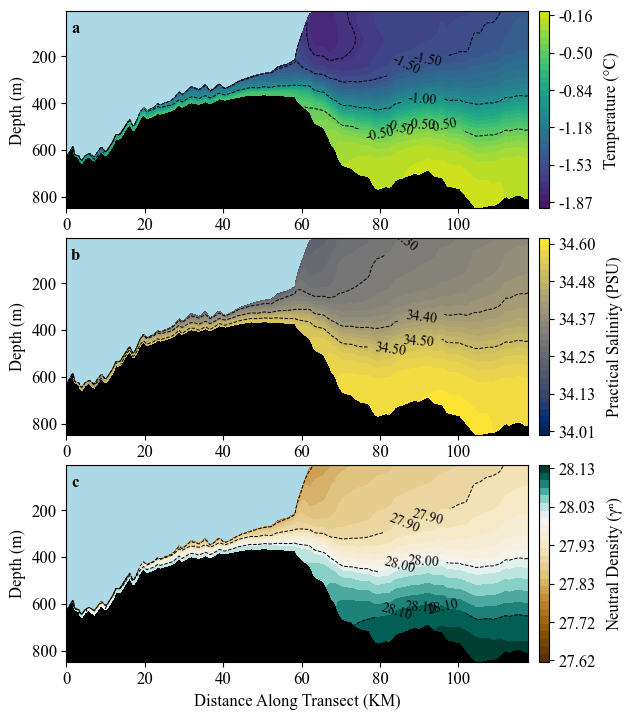

In [45]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_2

fig, axs = plt.subplots(3, 1, figsize=(160/25.4, 180/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_2, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_2, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_2)
vmax_temp = np.nanmax(temp_section_2)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_2, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_2, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_2)
vmax = np.nanmax(salt_section_2)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_2)
vmax = np.nanmax(gamma_n_section_2)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_2, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_2, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})


# Add subplot labels (a., b., c.)
labels = ['a', 'b', 'c']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_B_Temp_Salt_Dens.jpg', dpi=500, bbox_inches='tight')
plt.show()


### Plotting Data with Parcels

In [258]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm

In [260]:
DSW_mask = (temp_section_2 > - 1.92) & (temp_section_2 < -1.8) & (salt_section_2 > 34.4) & (gamma_n_section_2 > 28.27)
mCDW_mask = (temp_section_2 > -1.7) & (temp_section_2 < 1.5) & (gamma_n_section_2 > 28) & (gamma_n_section_2 < 28.27)
ASW_mask = (gamma_n_section_2 < 28)

In [262]:
water_parcels = np.full(temp_section_2.shape, np.nan)
water_parcels[DSW_mask] = 0.5 # mode 1 melting
water_parcels[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

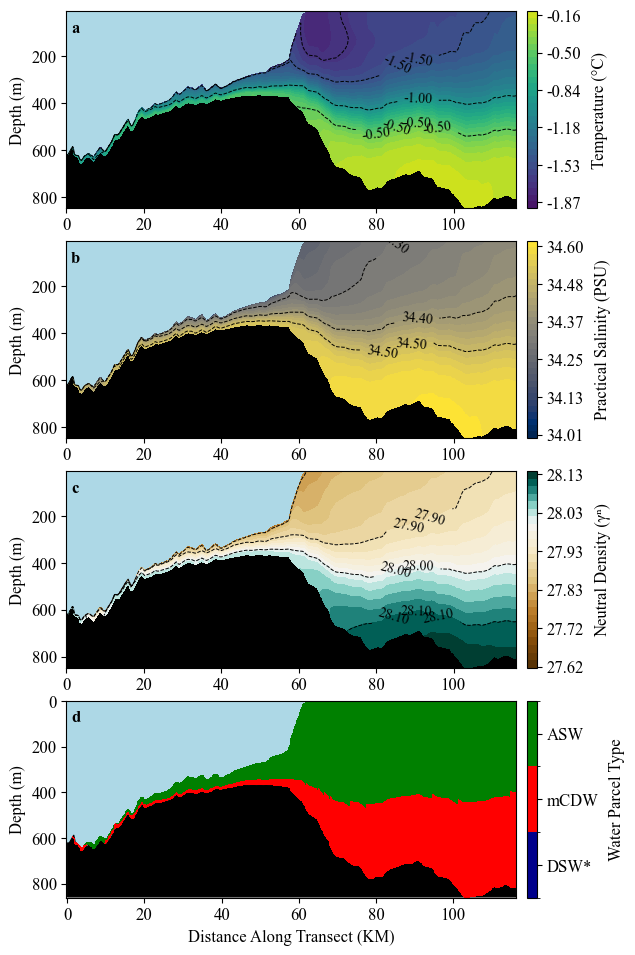

In [275]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_2

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_2, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_2, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_2)
vmax_temp = np.nanmax(temp_section_2)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_2, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_2, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_2)
vmax = np.nanmax(salt_section_2)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_2)
vmax = np.nanmax(gamma_n_section_2)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_2, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_2, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec.max(axis=0), 855, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot Labels
labels = ['a', 'b', 'c', 'd']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_B_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


# Cross Section for C to C'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import griddata
import gsw
from scipy.io import savemat
from scipy.io import loadmat
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

### Prepping Data (Cross Section Spatial Cords)

In [9]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1034534.06023618, 1096302.0333 
ymin, ymax = -2086972.74179876, -2185202.4510

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line = np.linspace(start_x, end_x, n_points)
y_line = np.linspace(start_y, end_y, n_points)

In [59]:
z_levels = temperature.shape[0]

In [157]:
# This interpolates the depths and variable data
z_levels = temperature.shape[0]
temp_section_3 = np.zeros((z_levels, n_points))
salt_section_3 = np.zeros((z_levels, n_points))
depth_section_3 = np.zeros((z_levels, n_points))

for k in range(z_levels):
    temp_k = temperature[k, :, :] 
    salt_k = salinity[k, :, :] 
    z_k = z_rho[k, :, :]         

    # Interpolate each level
    points = np.column_stack((X.ravel(), Y.ravel()))
    temp_section_3[k, :] = griddata(points, temp_k.ravel(), (x_line, y_line), method='linear')
    salt_section_3[k, :] = griddata(points, salt_k.ravel(), (x_line, y_line), method='linear')
    depth_section_3[k, :] = griddata(points, z_k.ravel(), (x_line, y_line), method='linear')


In [13]:
# Saves these variables as a .npy file, so I don't have to wait to interpolate them again in the future.
np.save("temp_section_3.npy", temp_section_3)
np.save("salt_section_3.npy", salt_section_3)
np.save("depth_section_3.npy", depth_section_3)

NameError: name 'temp_section_3' is not defined

In [15]:
# Loads these variables back in
temp_section_3 = np.load("temp_section_3.npy")
salt_section_3 = np.load("salt_section_3.npy")
depth_section_3 = np.load("depth_section_3.npy")

In [163]:
print("Shallowest depth (max):", np.max(depth_section_3))
print("Deepest depth (min):", np.min(depth_section_3))

Shallowest depth (max): -4.600409933309459
Deepest depth (min): -826.8992747870509


### Calculating / Prepping Neutral Densities

In [165]:
# This section calculates the neutral densities based off of the depth, salinity and temperature data from the previous cell ^^^

# Calculating absolute pressure from z_rho depth:
depth = depth_section_3
lat = -68.5    # This refers to the centre of the CIS
absolute_pressure = gsw.p_from_z(depth, lat)
sea_pressure = absolute_pressure - 10.1325
p = sea_pressure

# Calculating salt and temp inputs
SP = salt_section_3 # This is practical salinity (PSU)
pt = temp_section_3 # This is potential temperature
lon = 152.5 # This refers to the centre of the CIS
lat = -68.5 # This refers to the centre of the CIS

# Need to convert potential temperature to in-situ temperature: bit awkward as it's a two-step process;
SA = gsw.SA_from_SP(SP, p, lon, lat) # This converts practical to absolute salinity
CT = gsw.CT_from_pt(SA, pt) # This converts potential to conservative temp
T = gsw.t_from_CT(SA, CT, p) # Finally, this converts conservative to in-situ temp, using the pressure inputs

# Saving the data
SP = SP
t = T
p = p

print(SP.shape)
print(t.shape)
print(p.shape)

# Save as .mat
savemat("gamma_n_inputs_section_3.mat", {"SP": SP, "t": t, "p": p})


(31, 300)
(31, 300)
(31, 300)


FROM HERE, open MATLAB and run the file 'calculating_gamma_n_for_cross_sections.mat'
ENSURE that you have downloaded these codes: https://www.teos-10.org/preteos10_software/neutral_density.html

In [167]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data = loadmat('gamma_n_outputs_section_3.mat')
gamma_n_section_3 = data['gamma_n']  # numpy array


### Ploting Data

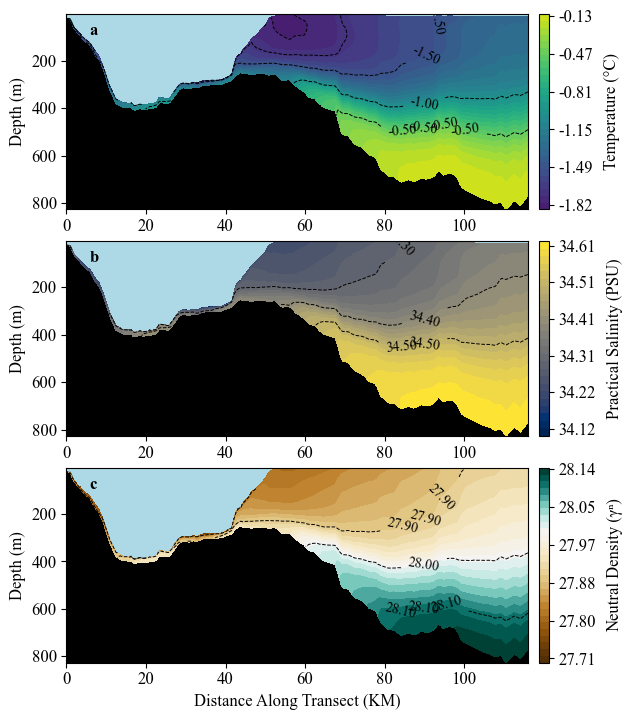

In [173]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_3

fig, axs = plt.subplots(3, 1, figsize=(160/25.4, 180/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_3, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_3, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_3)
vmax_temp = np.nanmax(temp_section_3)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_3, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_3, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_3)
vmax = np.nanmax(salt_section_3)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_3)
vmax = np.nanmax(gamma_n_section_3)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_3, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_3, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})


# Add subplot labels (a., b., c.)
labels = ['a', 'b', 'c']
for i, ax in enumerate(axs):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_C_Temp_Salt_Dens.jpg', dpi=500, bbox_inches='tight')
plt.show()


### Plotting Data with Parcels

In [17]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm

In [19]:
DSW_mask = (temp_section_3 > - 1.92) & (temp_section_3 < -1.8) & (salt_section_3 > 34.4) & (gamma_n_section_3 > 28.27)
mCDW_mask = (temp_section_3 > -1.7) & (temp_section_3 < 1.5) & (gamma_n_section_3 > 28) & (gamma_n_section_3 < 28.27)
ASW_mask = (gamma_n_section_3 < 28)

NameError: name 'gamma_n_section_3' is not defined

In [179]:
water_parcels = np.full(temp_section_3.shape, np.nan)
water_parcels[DSW_mask] = 0.5 # mode 1 melting
water_parcels[mCDW_mask] = 1.5 # mode 2 melting
water_parcels[ASW_mask] = 2.5 # mode 3 melting


In [181]:
water_parcels = np.full(temp_section_3.shape, np.nan)
water_parcels[DSW_mask] = 0.5 # mode 1 melting
water_parcels[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

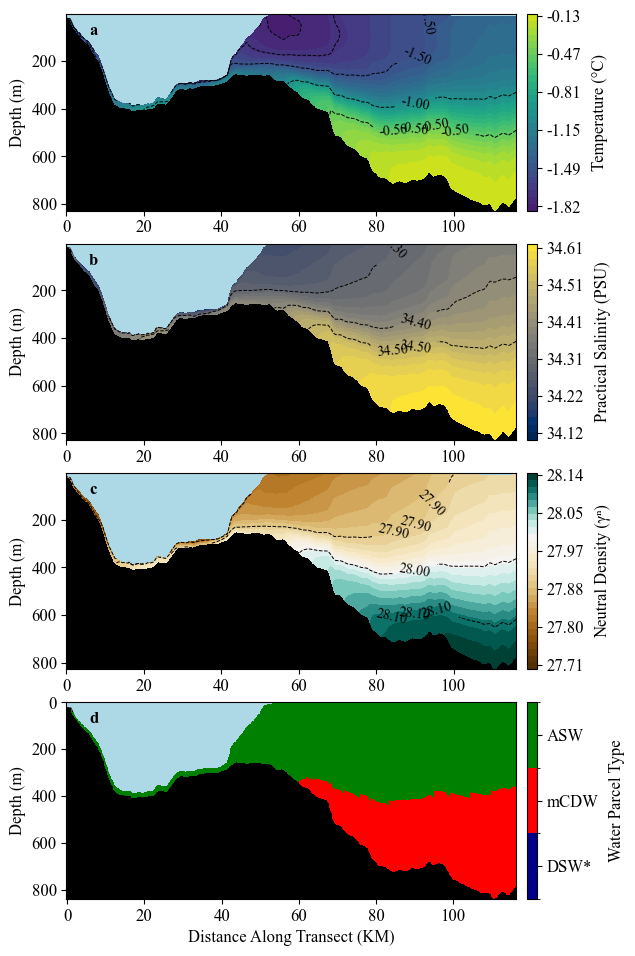

In [223]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_3

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_3, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_3, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_3)
vmax_temp = np.nanmax(temp_section_3)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_3, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_3, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_3)
vmax = np.nanmax(salt_section_3)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_3)
vmax = np.nanmax(gamma_n_section_3)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_3, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_3, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec.max(axis=0), 835, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot labels
labels = ['a', 'b', 'c', 'd']
for i, ax in enumerate(axs):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_C_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


# Plotting three cross sections in one figure

### RUN THESE CELLS FIRST

In [157]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data1 = loadmat('gamma_n_outputs_section_1.mat')
gamma_n_section_1 = data1['gamma_n']  # numpy array


In [159]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data2 = loadmat('gamma_n_outputs_section_2.mat')
gamma_n_section_2 = data2['gamma_n']  # numpy array


In [161]:
# After calculating gamma_n in MATLAB, run these lines to extract the data from the .mat file.

data3 = loadmat('gamma_n_outputs_section_3.mat')
gamma_n_section_3 = data3['gamma_n']  # numpy array


In [163]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1078998.1917, 1134587.8693
ymin, ymax = -2072930.4516, -2161360.5337

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line1 = np.linspace(start_x, end_x, n_points)
y_line1 = np.linspace(start_y, end_y, n_points)

In [165]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1049863.9700000092852861, 1112546.3867892120033503  
ymin, ymax = -2074869.5600000144913793, -2174544.8276608600281179 

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line2 = np.linspace(start_x, end_x, n_points)
y_line2 = np.linspace(start_y, end_y, n_points)

In [167]:
# ROI: this is a transect line which runs through the CIS - 
xmin, xmax = 1034534.06023618, 1096302.0333 
ymin, ymax = -2086972.74179876, -2185202.4510

start_x, start_y = xmin, ymin
end_x, end_y = xmax, ymax

n_points = 300

x_line3 = np.linspace(start_x, end_x, n_points)
y_line3 = np.linspace(start_y, end_y, n_points)

In [201]:
z_levels = temperature.shape[0]

In [171]:
# Loads these variables back in
temp_section_1 = np.load("temp_section_1.npy")
salt_section_1 = np.load("salt_section_1.npy")
depth_section_1 = np.load("depth_section_1.npy")

In [173]:
# Loads these variables back in
temp_section_2 = np.load("temp_section_2.npy")
salt_section_2 = np.load("salt_section_2.npy")
depth_section_2 = np.load("depth_section_2.npy")

In [175]:
# Loads these variables back in
temp_section_3 = np.load("temp_section_3.npy")
salt_section_3 = np.load("salt_section_3.npy")
depth_section_3 = np.load("depth_section_3.npy")

In [177]:
DSW_mask = (temp_section_1 > - 1.92) & (temp_section_1 < -1.8) & (salt_section_1 > 34.4) & (gamma_n_section_1 > 28.27)
mCDW_mask = (temp_section_1 > -1.7) & (temp_section_1 < 1.5) & (gamma_n_section_1 > 28) & (gamma_n_section_1 < 28.27)
ASW_mask = (gamma_n_section_1 < 28)
water_parcels1 = np.full(temp_section_1.shape, np.nan)
water_parcels1[DSW_mask] = 0.5 # mode 1 melting
water_parcels1[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels1[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

In [179]:
DSW_mask = (temp_section_2 > - 1.92) & (temp_section_2 < -1.8) & (salt_section_2 > 34.4) & (gamma_n_section_2 > 28.27)
mCDW_mask = (temp_section_2 > -1.7) & (temp_section_2 < 1.5) & (gamma_n_section_2 > 28) & (gamma_n_section_2 < 28.27)
ASW_mask = (gamma_n_section_2 < 28)
water_parcels2 = np.full(temp_section_2.shape, np.nan)
water_parcels2[DSW_mask] = 0.5 # mode 1 melting
water_parcels2[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels2[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

In [181]:
DSW_mask = (temp_section_3 > - 1.92) & (temp_section_3 < -1.8) & (salt_section_3 > 34.4) & (gamma_n_section_3 > 28.27)
mCDW_mask = (temp_section_3 > -1.7) & (temp_section_3 < 1.5) & (gamma_n_section_3 > 28) & (gamma_n_section_3 < 28.27)
ASW_mask = (gamma_n_section_3 < 28)
water_parcels3 = np.full(temp_section_3.shape, np.nan)
water_parcels3[DSW_mask] = 0.5 # mode 1 melting
water_parcels3[mCDW_mask & ~DSW_mask] = 1.5 # mode 2 melting
water_parcels3[ASW_mask & ~DSW_mask & ~mCDW_mask] = 2.5 # mode 3 melting

In [215]:
dx = np.diff(x_line1)
dy = np.diff(y_line1)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec1 = np.tile(dist_along_km, (z_levels, 1))
Z_sec1 = -depth_section_1

In [217]:
dx = np.diff(x_line2)
dy = np.diff(y_line2)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec2 = np.tile(dist_along_km, (z_levels, 1))
Z_sec2 = -depth_section_2

In [219]:
dx = np.diff(x_line3)
dy = np.diff(y_line3)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec3 = np.tile(dist_along_km, (z_levels, 1))
Z_sec3 = -depth_section_3

### individual plots

In [209]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec1 = np.tile(dist_along_km, (z_levels, 1))
Z_sec1 = -depth_section_1

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec1, Z_sec1, temp_section_1, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec1, Z_sec1, temp_section_1, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec1.min(), Z_sec1.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_1)
vmax_temp = np.nanmax(temp_section_1)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec1.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec1.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec1, Z_sec1, salt_section_1, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec1, Z_sec1, salt_section_1, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec1.min(), Z_sec1.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_1)
vmax = np.nanmax(salt_section_1)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec1.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec1.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_1)
vmax = np.nanmax(gamma_n_section_1)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec1, Z_sec1, gamma_n_section_1, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec1, Z_sec1, gamma_n_section_1, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec1.min(), Z_sec1.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec1.min(axis=0), 8.614647598124701, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec1.max(axis=0), 893.8812613581615, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec1, Z_sec1, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec1.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec1.max(axis=0), 905, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot Labels
labels = ['a. i', 'a. ii', 'a. iii', 'a. iv']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_A_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


NameError: name 'x_line' is not defined

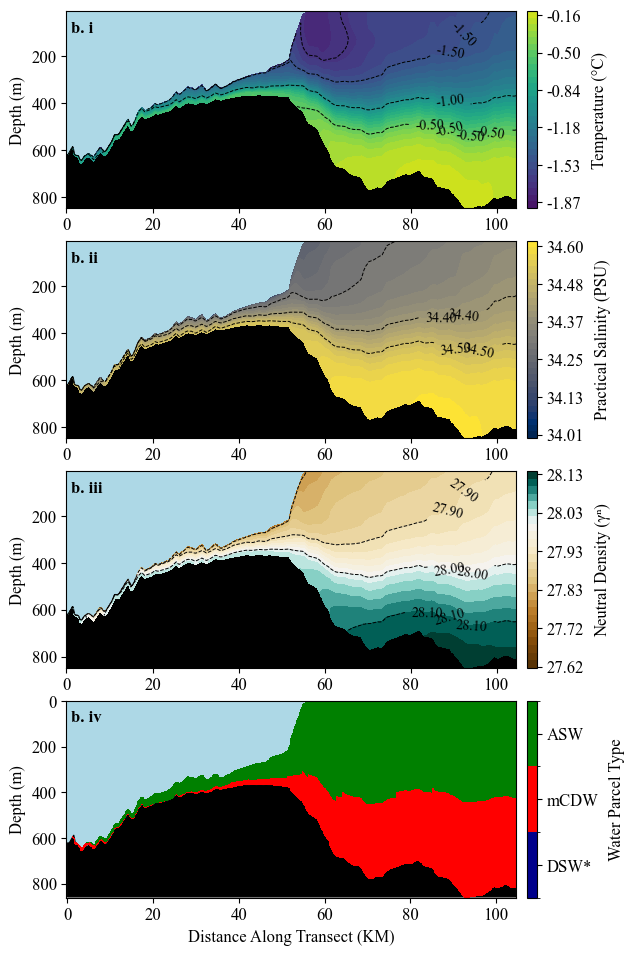

In [89]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_2

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_2, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_2, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_2)
vmax_temp = np.nanmax(temp_section_2)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_2, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_2, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_2)
vmax = np.nanmax(salt_section_2)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_2)
vmax = np.nanmax(gamma_n_section_2)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_2, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_2, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 8.825731341529426, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 846.9996779440872, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec.max(axis=0), 855, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot Labels
labels = ['b. i', 'b. ii', 'b. iii', 'b. iv']
for i, ax in enumerate(axs):
    ax.text(0.01, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_B_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


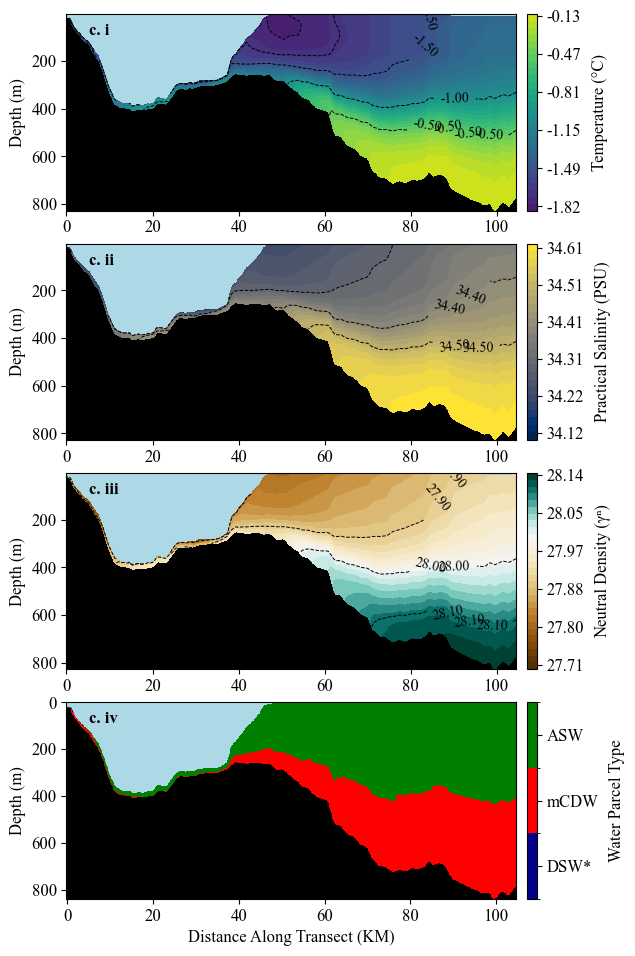

In [93]:
# Calculating the x-axis and prepping plot outlines
dx = np.diff(x_line)
dy = np.diff(y_line)
dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))  # in meters
dist_along_km = dist_along / 1000.0
X_sec = np.tile(dist_along_km, (z_levels, 1))
Z_sec = -depth_section_3

fig, axs = plt.subplots(4, 1, figsize=(160/25.4, 240/25.4))

############################## TEMPERATURE PLOT ##############################
cf0 = axs[0].contourf(X_sec, Z_sec, temp_section_3, levels=30, cmap='viridis', vmin=-2, vmax=0)

# Plotting the contour lines
levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
#levels_temp = [-1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2]
contours_temp = axs[0].contour(X_sec, Z_sec, temp_section_3, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
label_x = 90
label_ys_temp = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))
manual_positions_temp = [(label_x, y) for y in label_ys_temp]
labels_temp = axs[0].clabel(contours_temp, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_temp)
for label in labels_temp:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin_temp = np.nanmin(temp_section_3)
vmax_temp = np.nanmax(temp_section_3)
ticks_temp = np.linspace(vmin_temp, vmax_temp, 6)
cbar0 = fig.colorbar(cf0, ax=axs[0], pad=0.02, ticks=ticks_temp)
cbar0.set_label("Temperature (°C)", fontsize=12, family="Times New Roman", labelpad=8)
cbar0.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks_temp])
cbar0.ax.tick_params(labelsize=12)
for label in cbar0.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[0].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[0].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[0].set_title("Line 1: A to A' - Temperature", fontsize=12, family="Times New Roman")
axs[0].invert_yaxis()
axs[0].tick_params(labelsize=12)
for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[0].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[0].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[0].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## SALINITY PLOT ##############################
cf1 = axs[1].contourf(X_sec, Z_sec, salt_section_3, levels=30, cmap='cividis')

# Plotting the contour lines
levels_salt = [34.3, 34.4, 34.5, 34.7]
#levels_salt = [34.3, 34.35, 34.4, 34.45, 34.5, 34.55, 34.6]
contours_salt = axs[1].contour(X_sec, Z_sec, salt_section_3, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_salt = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))
manual_positions_salt = [(label_x, y) for y in label_ys_salt]
labels_salt = axs[1].clabel(contours_salt, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_salt)
for label in labels_salt:
    label.set_fontname("Times New Roman")

# Creating the colourbar
vmin = np.nanmin(salt_section_3)
vmax = np.nanmax(salt_section_3)
ticks = np.linspace(vmin, vmax, 6)
cbar1 = fig.colorbar(cf1, ax=axs[1], pad=0.02, ticks=ticks)
cbar1.set_label("Practical Salinity (PSU)", fontsize=12, family="Times New Roman", labelpad=8)
cbar1.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar1.ax.tick_params(labelsize=12)
for label in cbar1.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[1].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[1].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[1].set_title("Line 1: A to A' - Salinity", fontsize=12, family="Times New Roman")
axs[1].invert_yaxis()
axs[1].tick_params(labelsize=12)
for label in (axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    label.set_fontname('Times New Roman')
    

axs[1].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[1].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[1].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## NEUTRAL DENSITY PLOT ##############################
# Customising the colourbar:
vmin = np.nanmin(gamma_n_section_3)
vmax = np.nanmax(gamma_n_section_3)
vcenter = 28.0 
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cf2 = axs[2].contourf(X_sec, Z_sec, gamma_n_section_3, levels=30, cmap='BrBG', norm=norm)

# Plotting the contour lines
levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
#levels_gamma = [27.7, 28.0, 28.27]
contours_gamma = axs[2].contour(X_sec, Z_sec, gamma_n_section_3, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
label_ys_gamma = np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))
manual_positions_gamma = [(label_x, y) for y in label_ys_gamma]
labels_gamma = axs[2].clabel(contours_gamma, fmt="%.2f", fontsize=10, colors='k', manual=manual_positions_gamma)
for label in labels_gamma:
    label.set_fontname("Times New Roman")

# Creating the colourbar
ticks = np.linspace(vmin, vmax, 6)
cbar2 = fig.colorbar(cf2, ax=axs[2], pad=0.02, ticks=ticks)
cbar2.set_label("Neutral Density (γⁿ)", fontsize=12, family="Times New Roman", labelpad=8)
cbar2.ax.set_yticklabels([f"{tick:.2f}" for tick in ticks])
cbar2.ax.tick_params(labelsize=12)
for label in cbar2.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
#axs[2].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[2].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
#axs[2].set_title("Line 1: A to A' - Neutral Density", fontsize=12, family="Times New Roman")
axs[2].invert_yaxis()
axs[2].tick_params(labelsize=12)
for label in (axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[2].fill_between(dist_along_km, Z_sec.min(axis=0), 4.600409933309459, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[2].fill_between(dist_along_km, Z_sec.max(axis=0), 826.8992747870509, color='black', zorder=0, label='Ocean Bathymetry')
#axs[2].legend(loc='upper left', prop={'family': 'Times New Roman', 'size': 12})

############################## WATER PARCEL PLOT ##############################

# Define colormap and boundaries
cmap = ListedColormap(['darkblue', 'red', 'green'])  
bounds = [0, 1, 2, 3]  
norm = BoundaryNorm(bounds, cmap.N)

cf3 = axs[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)

# Creating the colourbar
cbar3 = fig.colorbar(cf3, ax=axs[3], pad=0.02, ticks=[0.5, 1.5, 2.5])
cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])  
cbar3.set_label("Water Parcel Type", fontsize=12, family="Times New Roman", labelpad=8)
cbar3.ax.tick_params(labelsize=12)
for label in cbar3.ax.get_yticklabels():
    label.set_fontname('Times New Roman')

# Customising the axes
axs[3].set_xlabel("Distance Along Transect (KM)", fontsize=12, family="Times New Roman")
axs[3].set_ylabel("Depth (m)", fontsize=12, family="Times New Roman")
axs[3].invert_yaxis()
axs[3].tick_params(labelsize=12)
for label in (axs[3].get_xticklabels() + axs[3].get_yticklabels()):
    label.set_fontname('Times New Roman')

axs[3].fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0, label='Cook Ice Shelf')
axs[3].fill_between(dist_along_km, Z_sec.max(axis=0), 835, color='black', zorder=0, label='Ocean Bathymetry')


# Subplot labels
labels = ['c. i', 'c. ii', 'c. iii', 'c. iv']
for i, ax in enumerate(axs):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontname='Times New Roman', va='top', ha='left', fontweight='bold')

plt.tight_layout(pad=0.3, h_pad=0.1)
#plt.savefig('Line_C_Temp_Salt_Dens_Parcel.jpg', dpi=500, bbox_inches='tight')
plt.show()


### looping

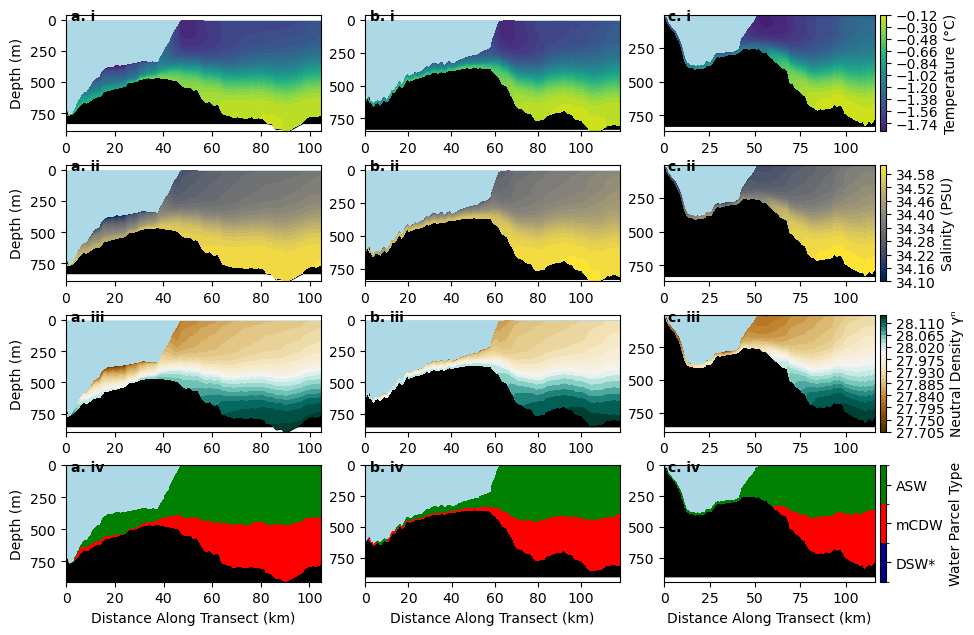

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, axs = plt.subplots(4, 3, figsize=(247/25.4, 160/25.4), sharex=False, sharey=False)

# Define subplot labels
subplot_labels = [
    ['a. i', 'b. i', 'c. i'],
    ['a. ii', 'b. ii', 'c. ii'],
    ['a. iii', 'b. iii', 'c. iii'],
    ['a. iv', 'b. iv', 'c. iv'],
]

# List of transects
transects = [
    (temp_section_1, salt_section_1, gamma_n_section_1, depth_section_1, x_line1, y_line1, water_parcels1),
    (temp_section_2, salt_section_2, gamma_n_section_2, depth_section_2, x_line2, y_line2, water_parcels2),
    (temp_section_3, salt_section_3, gamma_n_section_3, depth_section_3, x_line3, y_line3, water_parcels3),
]

for col, (temp, salt, gamma, depth, x_line, y_line, water_parcels) in enumerate(transects):
    # Distance calculation
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))
    dist_along_km = dist_along / 1000.0
    X_sec = np.tile(dist_along_km, (depth.shape[0], 1))
    Z_sec = -depth

    # Show colorbars only on last column
    show_cbar = col == 2
    # Show y-axis label only for first column
    show_ylabel = col == 0

    ################ TEMPERATURE ################
    ax = axs[0, col]
    cf0 = ax.contourf(X_sec, Z_sec, temp, levels=30, cmap='viridis', vmin=-2, vmax=0)
    if show_cbar:
        cbar = fig.colorbar(cf0, ax=ax, pad=0.02)
        cbar.set_label("Temperature (°C)", fontsize=10)
    ax.invert_yaxis()
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    ax.text(0.02, 0.95, subplot_labels[0][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    # Shading
    ax.fill_between(dist_along_km, Z_sec.min(axis=0), 4.6, color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), 827, color='black', zorder=0)
    if not show_ylabel:
        ax.set_ylabel('')  # remove label but keep ticks

    ################ SALINITY ################
    ax = axs[1, col]
    cf1 = ax.contourf(X_sec, Z_sec, salt, levels=30, cmap='cividis')
    if show_cbar:
        cbar = fig.colorbar(cf1, ax=ax, pad=0.02)
        cbar.set_label("Salinity (PSU)", fontsize=10)
    ax.invert_yaxis()
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    ax.text(0.02, 0.95, subplot_labels[1][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    ax.fill_between(dist_along_km, Z_sec.min(axis=0), 4.6, color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), 827, color='black', zorder=0)
    if not show_ylabel:
        ax.set_ylabel('')

    ################ NEUTRAL DENSITY ################
    ax = axs[2, col]
    norm = colors.TwoSlopeNorm(vmin=np.nanmin(gamma), vcenter=28.0, vmax=np.nanmax(gamma))
    cf2 = ax.contourf(X_sec, Z_sec, gamma, levels=30, cmap='BrBG', norm=norm)
    if show_cbar:
        cbar = fig.colorbar(cf2, ax=ax, pad=0.02)
        cbar.set_label("Neutral Density γⁿ", fontsize=10)
    ax.invert_yaxis()
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    ax.text(0.02, 0.95, subplot_labels[2][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    ax.fill_between(dist_along_km, Z_sec.min(axis=0), 4.6, color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), 850, color='black', zorder=0)
    if not show_ylabel:
        ax.set_ylabel('')

    ################ WATER PARCELS ################
    ax = axs[3, col]
    cmap = ListedColormap(['darkblue', 'red', 'green'])
    bounds = [0, 1, 2, 3]
    norm = BoundaryNorm(bounds, cmap.N)
    cf3 = ax.pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)
    if show_cbar:
        cbar = fig.colorbar(cf3, ax=ax, pad=0.02, ticks=[0.5, 1.5, 2.5])
        cbar.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])
        cbar.set_label("Water Parcel Type", fontsize=10)
    ax.invert_yaxis()
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Distance Along Transect (km)")
    ax.text(0.02, 0.95, subplot_labels[3][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    ax.fill_between(dist_along_km, Z_sec.min(axis=0), 0, color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), 900, color='black', zorder=0)
    if not show_ylabel:
        ax.set_ylabel('')

plt.tight_layout(pad=0.5, h_pad=0.3, w_pad=0.3)
plt.show()


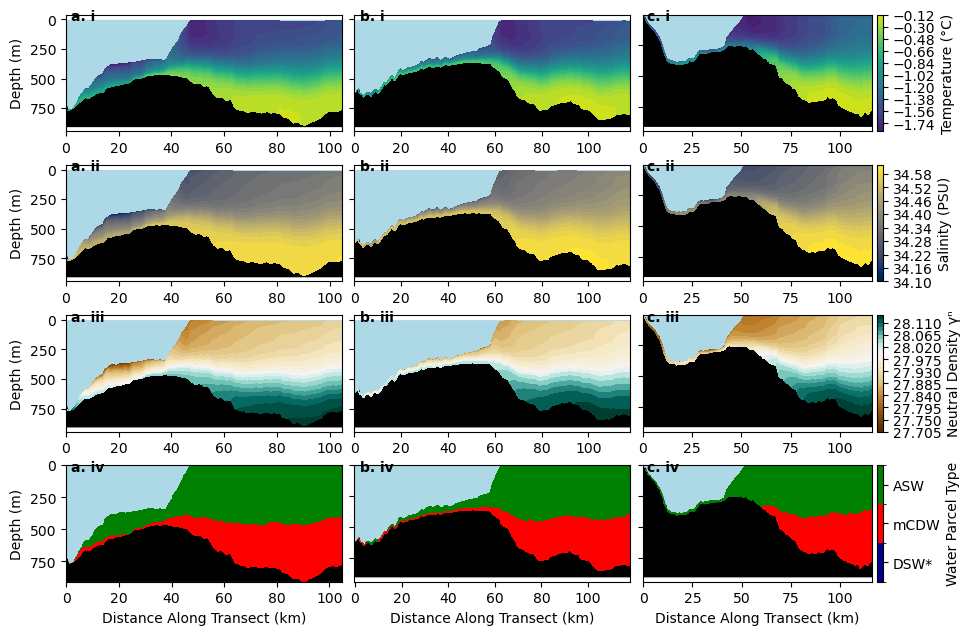

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, axs = plt.subplots(4, 3, figsize=(247/25.4, 160/25.4), sharex=False, sharey=False)

# Subplot labels
subplot_labels = [
    ['a. i', 'b. i', 'c. i'],
    ['a. ii', 'b. ii', 'c. ii'],
    ['a. iii', 'b. iii', 'c. iii'],
    ['a. iv', 'b. iv', 'c. iv'],
]

# Transect data
transects = [
    (temp_section_1, salt_section_1, gamma_n_section_1, depth_section_1, x_line1, y_line1, water_parcels1),
    (temp_section_2, salt_section_2, gamma_n_section_2, depth_section_2, x_line2, y_line2, water_parcels2),
    (temp_section_3, salt_section_3, gamma_n_section_3, depth_section_3, x_line3, y_line3, water_parcels3),
]

# Shading limits
ice_shelf_top = 4.6
ice_shelf_bottom = 0
ocean_top = 827
ocean_bottom = 900

for col, (temp, salt, gamma, depth, x_line, y_line, water_parcels) in enumerate(transects):
    # Compute distance along transect
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))
    dist_along_km = dist_along / 1000.0
    X_sec = np.tile(dist_along_km, (depth.shape[0], 1))
    Z_sec = -depth

    # Show colorbar only for rightmost column
    show_cbar = col == 2
    # Show y-axis label only for first column
    show_ylabel = col == 0

    ################ TEMPERATURE ################
    ax = axs[0, col]
    cf0 = ax.contourf(X_sec, Z_sec, temp, levels=30, cmap='viridis', vmin=-2, vmax=0)
    if show_cbar:
        cbar = fig.colorbar(cf0, ax=ax, pad=0.02)
        cbar.set_label("Temperature (°C)", fontsize=10)
    ax.invert_yaxis()
    ax.text(0.02, 0.95, subplot_labels[0][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])
    # Shading (fixed for inverted y-axis)
    ax.fill_between(dist_along_km, ice_shelf_top, Z_sec.min(axis=0), color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), ocean_bottom, color='black', zorder=0)

    ################ SALINITY ################
    ax = axs[1, col]
    cf1 = ax.contourf(X_sec, Z_sec, salt, levels=30, cmap='cividis')
    if show_cbar:
        cbar = fig.colorbar(cf1, ax=ax, pad=0.02)
        cbar.set_label("Salinity (PSU)", fontsize=10)
    ax.invert_yaxis()
    ax.text(0.02, 0.95, subplot_labels[1][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])
    ax.fill_between(dist_along_km, ice_shelf_top, Z_sec.min(axis=0), color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), ocean_bottom, color='black', zorder=0)

    ################ NEUTRAL DENSITY ################
    ax = axs[2, col]
    norm = colors.TwoSlopeNorm(vmin=np.nanmin(gamma), vcenter=28.0, vmax=np.nanmax(gamma))
    cf2 = ax.contourf(X_sec, Z_sec, gamma, levels=30, cmap='BrBG', norm=norm)
    if show_cbar:
        cbar = fig.colorbar(cf2, ax=ax, pad=0.02)
        cbar.set_label("Neutral Density γⁿ", fontsize=10)
    ax.invert_yaxis()
    ax.text(0.02, 0.95, subplot_labels[2][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])
    ax.fill_between(dist_along_km, ice_shelf_top, Z_sec.min(axis=0), color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), ocean_bottom, color='black', zorder=0)

    ################ WATER PARCELS ################
    ax = axs[3, col]
    cmap = ListedColormap(['darkblue', 'red', 'green'])
    bounds = [0, 1, 2, 3]
    norm = BoundaryNorm(bounds, cmap.N)
    cf3 = ax.pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap, norm=norm)
    if show_cbar:
        cbar = fig.colorbar(cf3, ax=ax, pad=0.02, ticks=[0.5, 1.5, 2.5])
        cbar.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])
        cbar.set_label("Water Parcel Type", fontsize=10)
    ax.invert_yaxis()
    ax.text(0.02, 0.95, subplot_labels[3][col], transform=ax.transAxes, fontsize=10, fontweight="bold")
    ax.set_xlabel("Distance Along Transect (km)")
    if show_ylabel:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])
    ax.fill_between(dist_along_km, ice_shelf_top, Z_sec.min(axis=0), color='lightblue', zorder=0)
    ax.fill_between(dist_along_km, Z_sec.max(axis=0), ocean_bottom, color='black', zorder=0)

plt.tight_layout(pad=0.5, h_pad=0.3, w_pad=0.3)
plt.show()


### COMBINING 

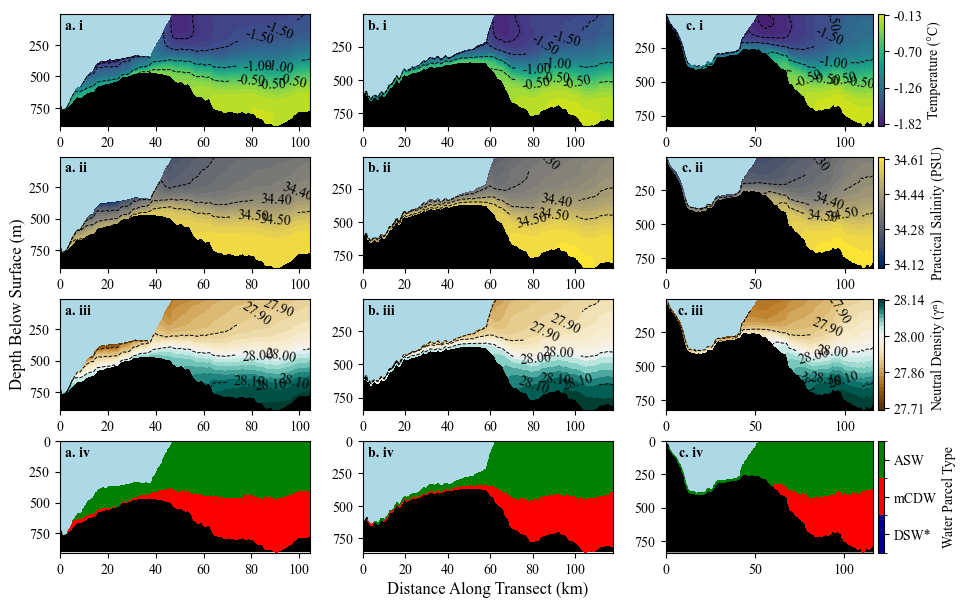

In [234]:
plt.rcParams.update({
    "font.size": 10,
    "font.family": "Times New Roman",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 10
})

fig, axs = plt.subplots(4, 3, figsize=(247/25.4, 160/25.4))  # 3 columns, 4 rows

def prepare_grid(x_line, y_line, z_levels):
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))
    dist_along_km = dist_along / 1000.0
    X_sec = np.tile(dist_along_km, (z_levels, 1))
    return X_sec, dist_along_km

fig.text(0.01, 0.5, "Depth Below Surface (m)", va='center', ha='center', rotation='vertical', fontsize=12, family='Times New Roman')

def plot_section(axs_col, X_sec, Z_sec, temp, salt, gamma_n, water_parcels,
                 ice_top, ice_bottom, column_label, col_idx):

    if col_idx == 2:
        x_text, ha_text = 0.18, 'right'
    else:
        x_text, ha_text = 0.02, 'left'

    # ----------------- Temperature -----------------
    cf0 = axs_col[0].contourf(X_sec, Z_sec, temp, levels=30, cmap='viridis', vmin=-2, vmax=0)
    levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
    contours_temp = axs_col[0].contour(X_sec, Z_sec, temp, levels=levels_temp, colors='k', linewidths=0.7, linestyles='dashed')
    manual_pos = [(90, y) for y in np.linspace(Z_sec.min(), Z_sec.max(), len(levels_temp))]
    axs_col[0].clabel(contours_temp, fmt="%.2f", manual=manual_pos)

    if col_idx == 2:  # Only last column gets colorbar
        cbar0 = fig.colorbar(cf0, ax=axs_col[0], pad=0.02, ticks=np.linspace(np.nanmin(temp), np.nanmax(temp), 4))
        cbar0.set_label("Temperature (°C)")
        cbar0.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[0].invert_yaxis()
    axs_col[0].tick_params(labelsize=10)
    axs_col[0].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[0].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[0].text(x_text, 0.95, f'{column_label} i', transform=axs_col[0].transAxes, va='top', ha=ha_text, fontweight='bold')

    # ----------------- Salinity -----------------
    cf1 = axs_col[1].contourf(X_sec, Z_sec, salt, levels=30, cmap='cividis')
    levels_salt = [34.3, 34.4, 34.5, 34.7]
    contours_salt = axs_col[1].contour(X_sec, Z_sec, salt, levels=levels_salt, colors='k', linewidths=0.7, linestyles='dashed')
    manual_pos = [(90, y) for y in np.linspace(Z_sec.min(), Z_sec.max(), len(levels_salt))]
    axs_col[1].clabel(contours_salt, fmt="%.2f", manual=manual_pos)

    if col_idx == 2:
        cbar1 = fig.colorbar(cf1, ax=axs_col[1], pad=0.02, ticks=np.linspace(np.nanmin(salt), np.nanmax(salt), 4))
        cbar1.set_label("Practical Salinity (PSU)")
        cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[1].invert_yaxis()
    axs_col[1].tick_params(labelsize=10)
    axs_col[1].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[1].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[1].text(x_text, 0.95, f'{column_label} ii', transform=axs_col[1].transAxes, va='top', ha=ha_text, fontweight='bold')

    # ----------------- Neutral Density -----------------
    vmin, vmax, vcenter = np.nanmin(gamma_n), np.nanmax(gamma_n), 28.0
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cf2 = axs_col[2].contourf(X_sec, Z_sec, gamma_n, levels=30, cmap='BrBG', norm=norm)
    levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
    contours_gamma = axs_col[2].contour(X_sec, Z_sec, gamma_n, levels=levels_gamma, colors='k', linewidths=0.7, linestyles='dashed')
    manual_pos = [(90, y) for y in np.linspace(Z_sec.min(), Z_sec.max(), len(levels_gamma))]
    axs_col[2].clabel(contours_gamma, fmt="%.2f", manual=manual_pos)

    if col_idx == 2:
        cbar2 = fig.colorbar(cf2, ax=axs_col[2], pad=0.02, ticks=np.linspace(vmin, vmax, 4))
        cbar2.set_label("Neutral Density (γⁿ)")
        cbar2.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[2].invert_yaxis()
    axs_col[2].tick_params(labelsize=10)
    axs_col[2].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[2].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[2].text(x_text, 0.95, f'{column_label} iii', transform=axs_col[2].transAxes, va='top', ha=ha_text, fontweight='bold')

    # ----------------- Water Parcels -----------------
    cmap_wp = ListedColormap(['darkblue', 'red', 'green'])
    norm_wp = BoundaryNorm([0,1,2,3], cmap_wp.N)
    cf3 = axs_col[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap_wp, norm=norm_wp)

    if col_idx == 2:
        cbar3 = fig.colorbar(cf3, ax=axs_col[3], pad=0.02, ticks=[0.5,1.5,2.5])
        cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])
        cbar3.set_label("Water Parcel Type")

    if col_idx == 1:
        axs_col[3].set_xlabel("Distance Along Transect (km)", fontsize = 12)
    
    axs_col[3].invert_yaxis()
    axs_col[3].tick_params(labelsize=10)
    axs_col[3].fill_between(X_sec[0], Z_sec.min(axis=0), 0, color='lightblue', zorder=0)
    axs_col[3].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[3].text(x_text, 0.95, f'{column_label} iv', transform=axs_col[3].transAxes, va='top', ha=ha_text, fontweight='bold')

# ----------------------------
plot_section(axs[:,0], X_sec1, Z_sec1, temp_section_1, salt_section_1, gamma_n_section_1, water_parcels1,
             ice_top=8.61, ice_bottom=893.88, column_label='a.', col_idx=0)

plot_section(axs[:,1], X_sec2, Z_sec2, temp_section_2, salt_section_2, gamma_n_section_2, water_parcels2,
             ice_top=8.82, ice_bottom=846.99, column_label='b.', col_idx=1)

plot_section(axs[:,2], X_sec3, Z_sec3, temp_section_3, salt_section_3, gamma_n_section_3, water_parcels3,
             ice_top=4.60, ice_bottom=826.89, column_label='c.', col_idx=2)

# ----------------------------
plt.tight_layout(pad=1.5, h_pad=0.1)
#plt.savefig('MELT_COMBINED.jpg', dpi=500, bbox_inches='tight')
plt.show()

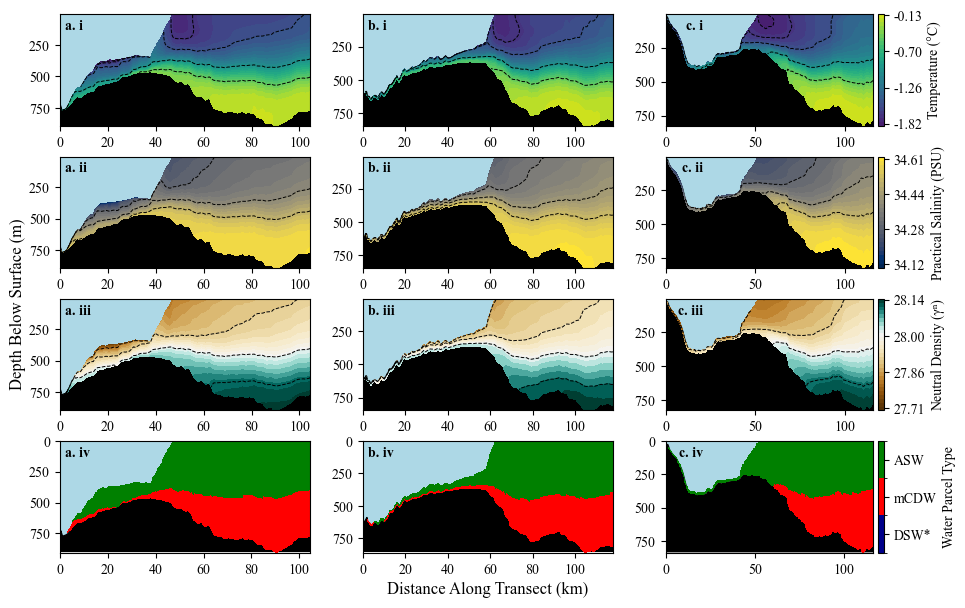

In [221]:


# ----------------------------
# Helper function to prepare distance and grid
def prepare_grid(x_line, y_line, z_levels):
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))
    dist_along_km = dist_along / 1000.0
    X_sec = np.tile(dist_along_km, (z_levels, 1))
    return X_sec, dist_along_km

# ----------------------------
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 10,
    "font.family": "Times New Roman",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 10
})

fig, axs = plt.subplots(4, 3, figsize=(247/25.4, 160/25.4))  # 3 columns, 4 rows

# ----------------------------
# Shared y-axis label for all rows
fig.text(0.01, 0.5, "Depth Below Surface (m)", va='center', ha='center',
         rotation='vertical', fontsize=12, family='Times New Roman')

# ----------------------------
def plot_section(axs_col, X_sec, Z_sec, temp, salt, gamma_n, water_parcels,
                 ice_top, ice_bottom, column_label, col_idx):

    # Determine text position for subplot labels
    if col_idx == 2:
        x_text, ha_text = 0.18, 'right'
    else:
        x_text, ha_text = 0.02, 'left'

    # ----------------- Temperature -----------------
    cf0 = axs_col[0].contourf(X_sec, Z_sec, temp, levels=30, cmap='viridis', vmin=-2, vmax=0)
    levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
    axs_col[0].contour(X_sec, Z_sec, temp, levels=levels_temp,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar0 = fig.colorbar(cf0, ax=axs_col[0], pad=0.02,
                             ticks=np.linspace(np.nanmin(temp), np.nanmax(temp), 4))
        cbar0.set_label("Temperature (°C)")
        cbar0.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[0].invert_yaxis()
    axs_col[0].tick_params(labelsize=10)
    axs_col[0].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[0].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[0].text(x_text, 0.95, f'{column_label} i', transform=axs_col[0].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Salinity -----------------
    cf1 = axs_col[1].contourf(X_sec, Z_sec, salt, levels=30, cmap='cividis')
    levels_salt = [34.3, 34.4, 34.5, 34.7]
    axs_col[1].contour(X_sec, Z_sec, salt, levels=levels_salt,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar1 = fig.colorbar(cf1, ax=axs_col[1], pad=0.02,
                             ticks=np.linspace(np.nanmin(salt), np.nanmax(salt), 4))
        cbar1.set_label("Practical Salinity (PSU)")
        cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[1].invert_yaxis()
    axs_col[1].tick_params(labelsize=10)
    axs_col[1].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[1].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[1].text(x_text, 0.95, f'{column_label} ii', transform=axs_col[1].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Neutral Density -----------------
    vmin, vmax, vcenter = np.nanmin(gamma_n), np.nanmax(gamma_n), 28.0
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cf2 = axs_col[2].contourf(X_sec, Z_sec, gamma_n, levels=30, cmap='BrBG', norm=norm)
    levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
    axs_col[2].contour(X_sec, Z_sec, gamma_n, levels=levels_gamma,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar2 = fig.colorbar(cf2, ax=axs_col[2], pad=0.02, ticks=np.linspace(vmin, vmax, 4))
        cbar2.set_label("Neutral Density (γⁿ)")
        cbar2.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[2].invert_yaxis()
    axs_col[2].tick_params(labelsize=10)
    axs_col[2].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[2].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[2].text(x_text, 0.95, f'{column_label} iii', transform=axs_col[2].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Water Parcels -----------------
    cmap_wp = ListedColormap(['darkblue', 'red', 'green'])
    norm_wp = BoundaryNorm([0,1,2,3], cmap_wp.N)
    cf3 = axs_col[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap_wp, norm=norm_wp)

    if col_idx == 2:
        cbar3 = fig.colorbar(cf3, ax=axs_col[3], pad=0.02, ticks=[0.5,1.5,2.5])
        cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])
        cbar3.set_label("Water Parcel Type")

    if col_idx == 1:  # x-axis only for middle column
        axs_col[3].set_xlabel("Distance Along Transect (km)", fontsize=12)

    axs_col[3].invert_yaxis()
    axs_col[3].tick_params(labelsize=10)
    axs_col[3].fill_between(X_sec[0], Z_sec.min(axis=0), 0, color='lightblue', zorder=0)
    axs_col[3].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[3].text(x_text, 0.95, f'{column_label} iv', transform=axs_col[3].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

# # ----------------------------
plot_section(axs[:,0], X_sec1, Z_sec1, temp_section_1, salt_section_1, gamma_n_section_1, water_parcels1,
             ice_top=8.61, ice_bottom=893.88, column_label='a.', col_idx=0)

plot_section(axs[:,1], X_sec2, Z_sec2, temp_section_2, salt_section_2, gamma_n_section_2, water_parcels2,
             ice_top=8.82, ice_bottom=846.99, column_label='b.', col_idx=1)

plot_section(axs[:,2], X_sec3, Z_sec3, temp_section_3, salt_section_3, gamma_n_section_3, water_parcels3,
             ice_top=4.60, ice_bottom=826.89, column_label='c.', col_idx=2)


# ----------------------------
plt.tight_layout(pad=1.5, h_pad=0.1)
#plt.savefig('MELT_COMBINED_unlabelled.jpg', dpi=500, bbox_inches='tight')
plt.show()

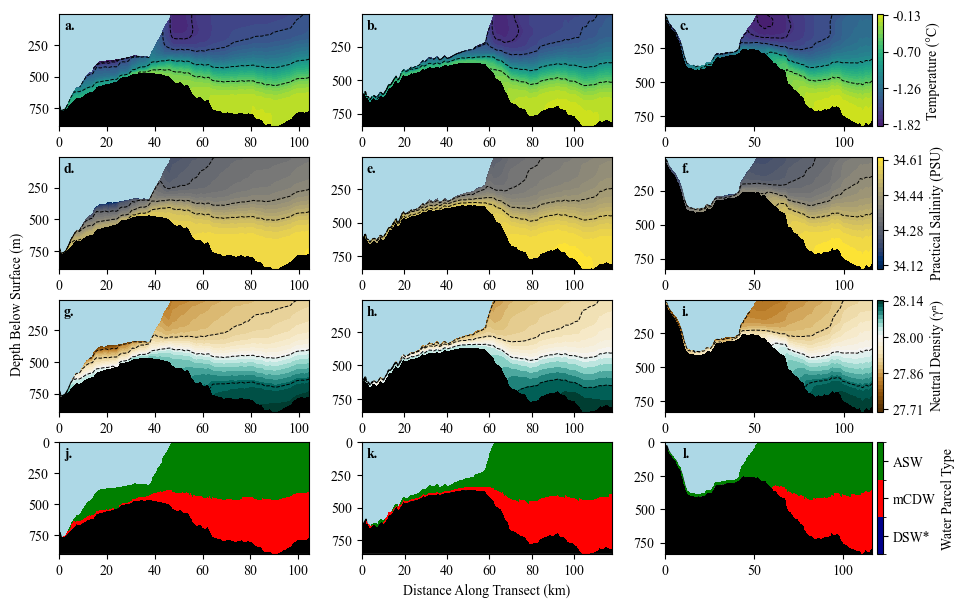

In [248]:
# ----------------------------
# Helper function to prepare distance and grid
def prepare_grid(x_line, y_line, z_levels):
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    dist_along = np.concatenate(([0], np.cumsum(np.sqrt(dx**2 + dy**2))))
    dist_along_km = dist_along / 1000.0
    X_sec = np.tile(dist_along_km, (z_levels, 1))
    return X_sec, dist_along_km

# ----------------------------
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 10,
    "font.family": "Times New Roman",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 10
})

fig, axs = plt.subplots(4, 3, figsize=(247/25.4, 160/25.4))  # 3 columns, 4 rows

# ----------------------------
# Shared y-axis label for all rows
fig.text(0.01, 0.5, "Depth Below Surface (m)", va='center', ha='center',
         rotation='vertical', fontsize=10, family='Times New Roman')

# ----------------------------
def plot_section(axs_col, X_sec, Z_sec, temp, salt, gamma_n, water_parcels,
                 ice_top, ice_bottom, subplot_labels, col_idx):

    # Determine text alignment based on column index
    if col_idx == 2:
        x_text, ha_text = 0.12, 'right'
    else:
        x_text, ha_text = 0.02, 'left'

    # ----------------- Temperature -----------------
    cf0 = axs_col[0].contourf(X_sec, Z_sec, temp, levels=30, cmap='viridis', vmin=-2, vmax=0)
    levels_temp = [-1.92, -1.8, -1.7, -1.5, -1.0, -0.5, 0]
    axs_col[0].contour(X_sec, Z_sec, temp, levels=levels_temp,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar0 = fig.colorbar(cf0, ax=axs_col[0], pad=0.02,
                             ticks=np.linspace(np.nanmin(temp), np.nanmax(temp), 4))
        cbar0.set_label("Temperature (°C)")
        cbar0.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[0].invert_yaxis()
    axs_col[0].tick_params(labelsize=10)
    axs_col[0].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[0].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[0].text(x_text, 0.95, subplot_labels[0], transform=axs_col[0].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Salinity -----------------
    cf1 = axs_col[1].contourf(X_sec, Z_sec, salt, levels=30, cmap='cividis')
    levels_salt = [34.3, 34.4, 34.5, 34.7]
    axs_col[1].contour(X_sec, Z_sec, salt, levels=levels_salt,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar1 = fig.colorbar(cf1, ax=axs_col[1], pad=0.02,
                             ticks=np.linspace(np.nanmin(salt), np.nanmax(salt), 4))
        cbar1.set_label("Practical Salinity (PSU)")
        cbar1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[1].invert_yaxis()
    axs_col[1].tick_params(labelsize=10)
    axs_col[1].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[1].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[1].text(x_text, 0.95, subplot_labels[1], transform=axs_col[1].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Neutral Density -----------------
    vmin, vmax, vcenter = np.nanmin(gamma_n), np.nanmax(gamma_n), 28.0
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cf2 = axs_col[2].contourf(X_sec, Z_sec, gamma_n, levels=30, cmap='BrBG', norm=norm)
    levels_gamma = [27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.27]
    axs_col[2].contour(X_sec, Z_sec, gamma_n, levels=levels_gamma,
                       colors='k', linewidths=0.7, linestyles='dashed')

    if col_idx == 2:
        cbar2 = fig.colorbar(cf2, ax=axs_col[2], pad=0.02, ticks=np.linspace(vmin, vmax, 4))
        cbar2.set_label("Neutral Density (γⁿ)")
        cbar2.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    axs_col[2].invert_yaxis()
    axs_col[2].tick_params(labelsize=10)
    axs_col[2].fill_between(X_sec[0], Z_sec.min(axis=0), ice_top, color='lightblue', zorder=0)
    axs_col[2].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[2].text(x_text, 0.95, subplot_labels[2], transform=axs_col[2].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

    # ----------------- Water Parcels -----------------
    cmap_wp = ListedColormap(['darkblue', 'red', 'green'])
    norm_wp = BoundaryNorm([0,1,2,3], cmap_wp.N)
    cf3 = axs_col[3].pcolormesh(X_sec, Z_sec, water_parcels, cmap=cmap_wp, norm=norm_wp)

    if col_idx == 2:
        cbar3 = fig.colorbar(cf3, ax=axs_col[3], pad=0.02, ticks=[0.5,1.5,2.5])
        cbar3.ax.set_yticklabels(['DSW*', 'mCDW', 'ASW'])
        cbar3.set_label("Water Parcel Type")

    if col_idx == 1:  # x-axis only for middle column
        axs_col[3].set_xlabel("Distance Along Transect (km)", fontsize=10)

    axs_col[3].invert_yaxis()
    axs_col[3].tick_params(labelsize=10)
    axs_col[3].fill_between(X_sec[0], Z_sec.min(axis=0), 0, color='lightblue', zorder=0)
    axs_col[3].fill_between(X_sec[0], Z_sec.max(axis=0), ice_bottom, color='black', zorder=0)
    axs_col[3].text(x_text, 0.95, subplot_labels[3], transform=axs_col[3].transAxes,
                    va='top', ha=ha_text, fontweight='bold')

# ----------------------------
# Example manual labels for each subplot
labels_a = ['a.', 'd.', 'g.', 'j.']
labels_b = ['b.', 'e.', 'h.', 'k.']
labels_c = ['c.', 'f.', 'i.', 'l.']

# ----------------------------
plot_section(axs[:,0], X_sec1, Z_sec1, temp_section_1, salt_section_1, gamma_n_section_1, water_parcels1,
             ice_top=8.61, ice_bottom=893.88, subplot_labels=labels_a, col_idx=0)

plot_section(axs[:,1], X_sec2, Z_sec2, temp_section_2, salt_section_2, gamma_n_section_2, water_parcels2,
             ice_top=8.82, ice_bottom=846.99, subplot_labels=labels_b, col_idx=1)

plot_section(axs[:,2], X_sec3, Z_sec3, temp_section_3, salt_section_3, gamma_n_section_3, water_parcels3,
             ice_top=4.60, ice_bottom=826.89, subplot_labels=labels_c, col_idx=2)

# ----------------------------
plt.tight_layout(pad=1.5, h_pad=0.1)
#plt.savefig('Final_fig_4.jpg', dpi=500, bbox_inches='tight')
plt.show()
